In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from utility import cart_to_sphe, sphe_to_cart, calculate_inter_angle_to_camera, get_sensor_filter, refractive_index_ice
from utility import calc_refracted_dir, pass_pressure_vessel, get_total_hist2d, draw_arrival_info, draw_FOV_boundary
from utility import draw_photon_with_lens
import itertools

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['font.size'] = 14

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-----------
### Main parameters

In [2]:
src_dir = "../dats/"
output_dir = "../output/"
diff = [20, 0, 0]
# diff = [30, 0, 10]

file_name = "ppc_log_x_%.2f_y_%.2f_z_%.2f_0.dat" % (diff[0], diff[1], diff[2])
dom_radius = 0.16510
camera_pos_sphe = np.array([0, np.pi/2])
camera_normal_vec = sphe_to_cart(camera_pos_sphe)
camera_pos_rad = dom_radius - 0.02 # Assume 5 cm apart from DOM boundary
camera_lens_rad = 0.005 
opening_angle = np.pi * 2 / 3 # = 22.86 when the camera opening angle is 120 degree(Using sin's law)
FOV = 120
wv = 405 #[nm]
scattering_length = 42.53 #[m]
absorption_length = 147.811 #[m]
ice_param = [scattering_length, absorption_length]

-----------
### 1. Read photon information from files

In this analysis, there are two main variables **(momentum, direction)**. Each variables are given by **spherical coordinates(phi, theta)** as a unit vector.
1. **Momentum** : Photon momentum on the DOM that tells us about photon track information(direction)
2. **Position** : Photon arrival point from center of the DOM <br/>

Using this two variables, we can check how it appears in the camera lens inside DOM. To get these data, you can use **PPC(Photon propagation code)** which is simulate photon interaction when it pass through the ice. <br/>
PPC : [https://icecube.wisc.edu/~dima/work/WISC/ppc/]

In [3]:
# Get photon information from first file at current setting
data = np.fromfile(src_dir + file_name, dtype='<f4')
photon_log = data.reshape(-1, 8)
momentum= photon_log[:,5:3:-1] 
position = photon_log[:,7:5:-1]

--------
### Draw raw arrival momentum 
We can check photon information which arrive on the surface of the DOM. It is raw data without any treatment like refraction on the DOM. 

In [ ]:
draw_arrival_info(momentum, position, "momentum", ice_param, diff, output_dir=output_dir, savefig=True, showfig=False)
draw_arrival_info(momentum, position, "position", ice_param, diff, output_dir=output_dir, savefig=True, showfig=False)

------
### 2. Refraction of photon
The photon will pass the pressure vessel and it cause refraction, There are two refraction **(ice -> vessel), (vessel -> inside of DOM)**. In the second case(vessel -> inside of DOM), photon goes high refractive index to low index. So, some photons cannot pass the boundary. After calculation of refraction, we will get the momentum and position vector of photon inside of DOM.**(in_momentum, in_position)** In the function, it will automatically remove photons cannot pass the inner DOM side. 

In [4]:
in_momentum, in_position = pass_pressure_vessel(position, momentum, refractive_index_ice(wv))

/home/jh/working_directory/cameraSim/cameraAnalysis/utility.py:142: RuntimeWarning: invalid value encountered in sqrt
  s2 = n * np.cross(N, np.cross(-N, s1)) - (N.T * np.sqrt(1 - n**2 * np.sum(cross * cross, axis=1))).T


In [ ]:
draw_arrival_info(in_momentum, in_position, "momentum", ice_param, diff, 
                      output_dir=output_dir, refraction=True, savefig=True, showfig=False)
draw_arrival_info(in_momentum, in_position, "position", ice_param, diff, 
                      output_dir=output_dir, refraction=True, savefig=True, showfig=False)

-----
### Draw the maximum range(FOV)
As camera has FOV(Field of view), the photon track will be filtered to satisfy the FOV condition.

In [ ]:
draw_FOV_boundary(camera_pos_sphe, 120, output_dir=output_dir, savefig=True, showfig=False)

## 3. Move from surface of pressure vessel to sensor
To get image information on the sensor, we need to considr the effect of pressure vessel because it makes refraction to the photon. So, we need to calculate refracted photon information using **Snell's law** and then filter the photon which can arrive in sensor. First, there are two refraction for the photon <br/>
1. Ice -> Pressure Veseel
2. Pressure vessel -> Interior of DOM<br/>

Naturally, it is important to calculate photon track inside of the vessel(between step 1 and 2). After calculation of two refraction, we can get photon information inside of the DOM(In this process, there are some photons which cannot pass the vessel due to refractive index). Then, we will check whether the photon track by these two steps<br/>
1. Whether the photon track will pass the camera lens area
2. Whether interior angle between photon momentum and lens normal vector is smaller than half of opening angle(FOV)<br/>

After finishing these all process, we can get photon information on the camera lens!

- Ref
- https://wiki.icecube.wisc.edu/index.php/Glass_Pressure_Vessel
- http://www.starkeffects.com/snells-law-vector.shtml

In [7]:
# Apply lens filter
lens_filter = get_sensor_filter(in_position, in_momentum, camera_pos_sphe, camera_lens_rad=camera_lens_rad, FOV=120)
momentum_on_lens = in_momentum[lens_filter]
position_on_lens = in_position[lens_filter]

In [8]:
draw_photon_with_lens(momentum_on_lens, position_on_lens, camera_pos_sphe, FOV, "momentum", ice_param, diff, 
                      output_dir=output_dir, onlylens=True, drawFOV=True, showall=True, savefig=True, showfig=False)
draw_photon_with_lens(momentum_on_lens, position_on_lens, camera_pos_sphe, FOV, "position", ice_param, diff, 
                      output_dir=output_dir, onlylens=True, drawFOV=True, showall=True, savefig=True, showfig=False)
draw_photon_with_lens(in_momentum, in_position, camera_pos_sphe, FOV, "momentum", ice_param, diff, 
                      output_dir=output_dir, drawFOV=True, showall=True, savefig=True, showfig=False)
draw_photon_with_lens(in_momentum, in_position, camera_pos_sphe, FOV, "position", ice_param, diff, 
                      output_dir=output_dir, drawFOV=True, showall=True, savefig=True, showfig=False)

------
## 4. Get all momentum histogram on the target by merging seperate files
The photon data are splitted if the size is larger than 256MB(which include 8388608 photon). So, we need to merge this files into histogram because the np.array is so large if we have them all in the memory. `get_total_histogram` function will collect every files and sum over the histogram. We can use `filter_lens` argument as true to get the photon information on the lens(This is default). Otherwise, we will get overall photon momentum information.

In [9]:
H, x_edges, y_edges = get_total_hist2d(file_name, 2, bins=40, show_position=False)

/home/jh/working_directory/cameraSim/cameraAnalysis/utility.py:142: RuntimeWarning: invalid value encountered in sqrt
  s2 = n * np.cross(N, np.cross(-N, s1)) - (N.T * np.sqrt(1 - n**2 * np.sum(cross * cross, axis=1))).T


1th file : 5440 photon arrive in lens
2th file : 3701 photon arrive in lens
The number of total photon on the lens : 9141


## Compare the result

Text(0.5,1,'Arrival momentum of the photon with FOV')

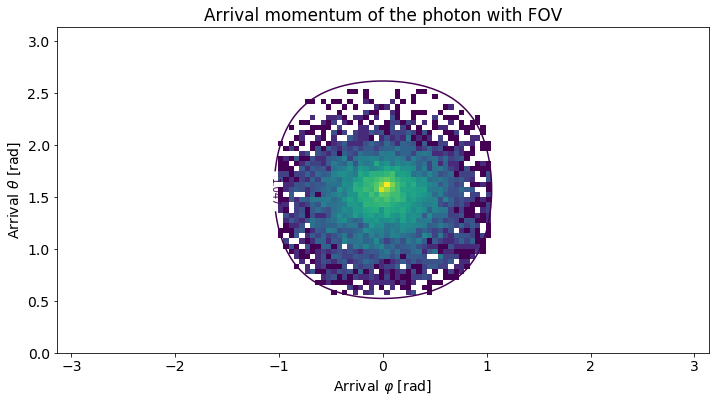

In [16]:
draw_FOV_boundary(camera_pos_sphe, 120, output_dir=output_dir, savefig=False, showfig=True)
plt.imshow(H, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], norm=LogNorm(), origin='low')
plt.xlim([-np.pi, np.pi])
plt.ylim([0, np.pi])
plt.title('Arrival momentum of the photon with FOV')